In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import pandas as pd
import altair as alt
from terra_mystica_models.features import parse_interim
from terra_mystica_models.data.make_dataset import TerraMysticaGame

In [3]:
pd.options.display.max_rows = 999

In [4]:
alt.renderers.enable("jupyterlab")

RendererRegistry.enable('jupyterlab')

In [5]:
all_games_df = parse_interim.read_interim_data()

## Basic validation

### Date

In [6]:
all_games_df["date"].min()

Timestamp('2013-02-10 02:40:12')

In [7]:
all_games_df["date"].max()

Timestamp('2020-01-31 21:19:11')

In [8]:
any(all_games_df["date"].isna())

False

### Map

In [9]:
any(all_games_df["map"].isna())

False

### Number of players

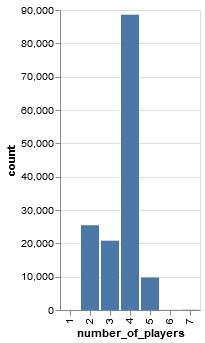

In [10]:
player_number_stats = (
    all_games_df["number_of_players"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "number_of_players", "number_of_players": "count"})
)
alt.Chart(player_number_stats).mark_bar().encode(x="number_of_players:O", y="count")

This one's actually a bit too skewed to really see, let's see the raw data

In [11]:
player_number_stats

,number_of_players,count
0,4,88610
1,2,25445
2,3,20793
3,5,9765
4,7,87
5,6,45
6,1,7


OK, to start I'll definitely focus on the 4 player games. But it looks like there would be enough of the 2 and 3 player games to be interesting. I almost certainly don't want the single player games, and I'll likely drop the 6 and 7, maybe even 5 player games from most or all analysis

In [12]:
all_games_df["map"].value_counts()

126fe960806d587c78546b30f1a90853b1ada468    94693
95a66999127893f5925a5f591d54f8bcb9a670e6    24465
be8f6ebf549404d015547152d5f2a1906ae8dd90    17949
fdb13a13cd48b7a3c3525f27e4628ff6905aa5b1     3638
91645cdb135773c2a7a50e5ca9cb18af54c664c4     3252
2afadc63f4d81e850b7c16fb21a1dcd29658c392      747
224736500d20520f195970eb0fd4c41df040c08c        3
735b073fd7161268bb2796c1275abda92acd8b1a        2
30b6ded823e53670624981abdb2c5b8568a44091        1
b109f78907d2cbd5699ced16572be46043558e41        1
c07f36f9e050992d2daf6d44af2bc51dca719c46        1
Name: map, dtype: int64

### Expansion factions

In [13]:
all_games_df['has_expansion_factions'].value_counts()

False    106840
True      37912
Name: has_expansion_factions, dtype: int64

### Dropped factions

In [14]:
all_games_df['has_dropped_faction'].value_counts()

False    122283
True      22469
Name: has_dropped_faction, dtype: int64

### Scoring tile columns

In [15]:
for n in range(1, 7):
    col = f"score_turn_{n}"
    if any(all_games_df[col].isna()):
        print(f"{col} has missing values")

score_turn_1 has missing values
score_turn_2 has missing values
score_turn_3 has missing values
score_turn_4 has missing values
score_turn_5 has missing values
score_turn_6 has missing values


Well that's no good. Let's see what's happening there

In [16]:
mask = all_games_df["score_turn_1"].isna()
all_games_df.loc[mask]

,date,map,number_of_players,original_map,has_expansion_factions,has_dropped_faction,file,score_turn_1,score_turn_2,score_turn_3,...,player_5_vp,player_6_vp,player_7_vp,player_1_vp_margin,player_2_vp_margin,player_3_vp_margin,player_4_vp_margin,player_5_vp_margin,player_6_vp_margin,player_7_vp_margin
wayne,2015-09-27 12:25:00,95a66999127893f5925a5f591d54f8bcb9a670e6,4,False,False,True,2015-09.json,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0.0,3.0,18.0,NaN,NaN,NaN
20170721firstgame,2017-08-30 11:25:01,126fe960806d587c78546b30f1a90853b1ada468,3,True,False,True,2017-08.json,NaN,NaN,NaN,...,NaN,NaN,NaN,0,9.0,2.0,NaN,NaN,NaN,NaN


In [17]:
def bunk_game_finder(game_name, json_name):
    """Get the full JSON representation of a weird game
    
    Parameters
    ----------
    game_name: str
        the name of the game (index in the DataFrame)
    json_name: str
        the name of the source json file ("file" column in DataFrame)
        
    Returns
    -------
    bunk_game: terra_mystica_models.data.make_dataset.TerraMysticaGame
        The weird game we're trying to find
    """
    json_dir = Path(".").resolve().parent / "data" / "raw"
    bad_json = json_dir / json_name
    with open(bad_json) as f:
        bad_json_data = json.load(f)
    for game in bad_json_data:
        if game["game"] == game_name:
            return TerraMysticaGame(game)

In [18]:
bg = bunk_game_finder("wayne", "2015-09.json")

In [19]:
bg._raw_game["events"]["global"]

{'faction-count': {'round': {'all': 4, '0': 4}},
 'drop-faction': {'round': {'all': 4, '1': 3, '2': 1}},
 '': {'round': {'6': 1, 'all': 6, '1': 1, '5': 1, '3': 1, '2': 1, '4': 1}}}

I think this game just got cancelled before it even started? Let's try the next one

In [20]:
bg = bunk_game_finder("20170721firstgame", "2017-08.json")

In [21]:
bg._raw_game["events"]["global"]

{'faction-count': {'round': {'all': 3, '0': 3}},
 'drop-faction': {'round': {'all': 3, '1': 2, '2': 1}},
 '': {'round': {'6': 1, 'all': 6, '1': 1, '5': 1, '2': 1, '3': 1, '4': 1}}}

Looks about the same

In [22]:
mask = all_games_df["score_turn_1"].isna()
all_games_df.loc[mask, [col for col in all_games_df.columns if col.startswith("score_turn")]]

,score_turn_1,score_turn_2,score_turn_3,score_turn_4,score_turn_5,score_turn_6
wayne,NaN,NaN,NaN,NaN,NaN,NaN
20170721firstgame,NaN,NaN,NaN,NaN,NaN,NaN


OK, so it's missing for all of them, that makes sense in this context. Let's see how many are missing turn 6

In [23]:
mask = all_games_df["score_turn_6"].isna()
all_games_df.loc[mask]

,date,map,number_of_players,original_map,has_expansion_factions,has_dropped_faction,file,score_turn_1,score_turn_2,score_turn_3,...,player_5_vp,player_6_vp,player_7_vp,player_1_vp_margin,player_2_vp_margin,player_3_vp_margin,player_4_vp_margin,player_5_vp_margin,player_6_vp_margin,player_7_vp_margin
wayne,2015-09-27 12:25:00,95a66999127893f5925a5f591d54f8bcb9a670e6,4,False,False,True,2015-09.json,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0.0,3.0,18.0,NaN,NaN,NaN
20170721firstgame,2017-08-30 11:25:01,126fe960806d587c78546b30f1a90853b1ada468,3,True,False,True,2017-08.json,NaN,NaN,NaN,...,NaN,NaN,NaN,0,9.0,2.0,NaN,NaN,NaN,NaN


Just the same two games

Now I have a function to clean that up, let's test it out

In [24]:
all_games_df = parse_interim.interim_full_pipe()

In [25]:
mask = all_games_df["score_turn_6"].isna()
all_games_df.loc[mask]

,date,map,number_of_players,original_map,has_expansion_factions,has_dropped_faction,file,score_turn_1,score_turn_2,score_turn_3,...,player_5_vp,player_6_vp,player_7_vp,player_1_vp_margin,player_2_vp_margin,player_3_vp_margin,player_4_vp_margin,player_5_vp_margin,player_6_vp_margin,player_7_vp_margin


Beauty

### Bonus Tiles

I should have already taken care of the NA values, let's check the distribution of these

In [26]:
bonus_cols = sorted([col for col in all_games_df.columns if col.startswith("BON")])
bonus_cols.pop(1)
bonus_cols.append("BON10")

In [27]:
assert not any(all_games_df[bonus_cols].isna().any(axis="columns"))

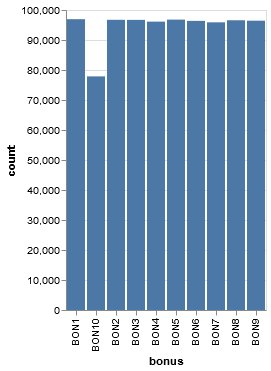

In [28]:
bonus_cols = sorted([col for col in all_games_df.columns if col.startswith("BON")])
bonus_cols.pop(1)
bonus_cols.append("BON10")
bonus_cols_stats = (
    all_games_df[bonus_cols]
    .sum()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "bonus", 0: "count"})
)
alt.Chart(bonus_cols_stats).mark_bar().encode(x="bonus", y="count")

Nice and uniform, except for Bonus10 which I think maybe got added later? Even that one though there's still plenty.

### Factions
This one might take a bit of transformation to get a proper feel for

In [29]:
faction_cols = sorted(
    [
        col
        for col in all_games_df.columns
        if col.endswith("faction") and not col.startswith("has_dropped")
    ]
)
all_factions = (
    all_games_df
    .melt(value_vars=faction_cols)
    .dropna()
    ["value"]
    .value_counts()
    .sort_values()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "faction", "value": "count"})
)
all_factions

,faction,count
0,shapeshifters,4428
1,acolytes,5901
2,riverwalkers,9647
3,dragonlords,10037
4,icemaidens,10697
5,fakirs,11216
6,yetis,13233
7,auren,14652
8,giants,18960
9,dwarves,19596


I feel like this should match, let's see

In [30]:
all_games_df["number_of_players"].sum() == all_factions["count"].sum()

True

Great, that's good to know

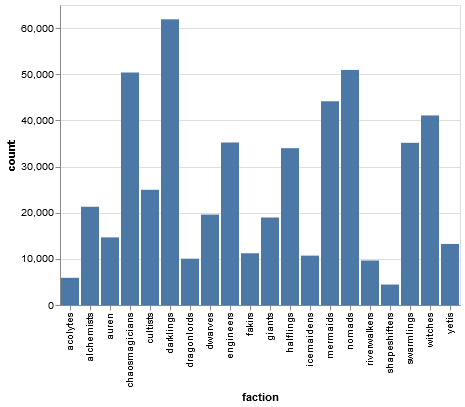

In [31]:
alt.Chart(all_factions).mark_bar().encode(x="faction", y="count")

Ok, there's actually some diffusion here. Let's subset it to just the ones without expansion factions (at least as I've tried to define that)

In [32]:
all_factions = (
    all_games_df
    .loc[~all_games_df["has_expansion_factions"]]
    .melt(value_vars=faction_cols)
    .dropna()
    ["value"]
    .value_counts()
    .sort_values()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "faction", "value": "count"})
)
all_factions

,faction,count
0,fakirs,7798
1,auren,12038
2,giants,14448
3,dwarves,15755
4,alchemists,16848
5,cultists,20132
6,halflings,27943
7,swarmlings,29122
8,engineers,30008
9,mermaids,34048


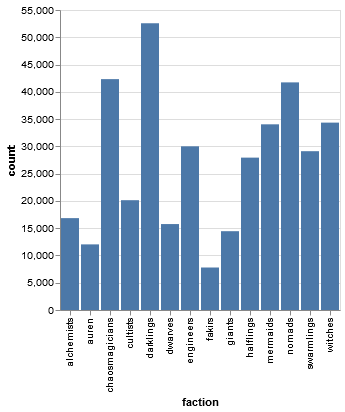

In [33]:
alt.Chart(all_factions).mark_bar().encode(x="faction", y="count")

Interesting, even dropping out expansions there's still some very clear favourites

OK, that's enough for now. I'll do another round later